<a href="https://colab.research.google.com/github/laurencleek/text_classification_workshop/blob/main/text_classification_maastricht.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>LLM Text Classification Workshop</h1>
<i>This notebook provides some basic code for practical applications of Large Language Models (LLMs) for text classification tasks. It focuses only on using the OpenAI API which is just one of the possible LLMs for text classification. It shows how to load data, pre-process data and set up a basic classification pipeline.</i>

<a href="https://github.com/laurencleek/text_classification_workshop"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>

---

This notebook is developed by [Lauren Leek](https://laurenleek.eu/).

---


# Overview
Set up a text classification pipeline using the OpenAI API (gpt 5 nano). The pipeline covers data loading, pre-processing, API usage, and basic validation. It uses the data from the "validation_sample_limited.xlsx" file, which contains 100 sentences with 'speech_identifiers', 'sentence', and 'label' columns for classifying sentences as 'descriptive' or 'normative'. This can be replaced by any dataset of choice.

### Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>


If you are viewing this notebook on Google Colab, you need to **uncomment and run** the following codeblock to install the dependencies.

Note that %%capture supresses the cell output.

---


In [ ]:
%%capture
!pip install pandas openai os getpass sklearn.metrics seaborn matplotlib string

## Load data

Load the data from the "validation_sample_limited.xlsx" (or your own datafile) into a pandas DataFrame. Display some of the data and info as good practice check.


In [ ]:
import pandas as pd

df = pd.read_excel("sample_data/validation_sample_limited.xlsx")

display(df.head())
display(df.info())

,sentence_id,speech_identifier,sentence,label
0,863941,2008-06-17_e.txt,"Against this backdrop, it is essential to elim...",normative
1,484125,2009-12-08_e.txt,"Indeed, the domestic financial institutions ha...",descriptive
2,536961,2007-03-30_e.txt,"Lending to households, household debt and hous...",descriptive
3,947025,2021-06-14_a.txt,"Furthermore, monetary policy implementation in...",normative
4,325809,2007-07-05_f.txt,Turnover in the UK and US foreign-exchange mar...,descriptive


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   sentence_id        1000 non-null   int64 
 1   speech_identifier  99 non-null     object
 2   sentence           99 non-null     object
 3   label              99 non-null     object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


None

## Preprocessing Data

Various pre-processing steps can be added here. Think of lowercasing, removing punctuation, removing stop words, tokenization, lemmatization, handling special characters and numbers, handling of rare words, etc.

Handle missing values and prepare the text data for classification.

In [ ]:
import string

def remove_punctuation(text):
  """Removes punctuation from a string."""
  if isinstance(text, str):
    return text.translate(str.maketrans('', '', string.punctuation))
  return text # Return non-string inputs as is

df['sentence_cleaned'] = df['sentence'].apply(remove_punctuation)
display(df.head())

,sentence_id,speech_identifier,sentence,label,sentence_cleaned
0,863941,2008-06-17_e.txt,"Against this backdrop, it is essential to elim...",normative,Against this backdrop it is essential to elimi...
1,484125,2009-12-08_e.txt,"Indeed, the domestic financial institutions ha...",descriptive,Indeed the domestic financial institutions hav...
2,536961,2007-03-30_e.txt,"Lending to households, household debt and hous...",descriptive,Lending to households household debt and house...
3,947025,2021-06-14_a.txt,"Furthermore, monetary policy implementation in...",normative,Furthermore monetary policy implementation in ...
4,325809,2007-07-05_f.txt,Turnover in the UK and US foreign-exchange mar...,descriptive,Turnover in the UK and US foreignexchange mark...


In [ ]:
# Check for missing values
display(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Verify that missing values have been removed
display(df.isnull().sum())
display(df.info())

,0
sentence_id,0
speech_identifier,901
sentence,901
label,901
sentence_cleaned,901


,0
sentence_id,0
speech_identifier,0
sentence,0
label,0
sentence_cleaned,0


<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, 0 to 98
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   sentence_id        99 non-null     int64 
 1   speech_identifier  99 non-null     object
 2   sentence           99 non-null     object
 3   label              99 non-null     object
 4   sentence_cleaned   99 non-null     object
dtypes: int64(1), object(4)
memory usage: 4.6+ KB


None

## Classify Dataset (subset)



Apply the classification function to a subset of the data.

**Reasoning**:

Define a Python function `classify_sentence` that takes a sentence as input and uses the OpenAI API to classify it as 'descriptive' or 'normative'.

In [ ]:
import openai
import os
from getpass import getpass

# Fetch the OpenAI API key securely.
# If running in a secure environment like Colab, you can use the secrets manager.
# In other environments, be cautious about how you handle API keys.
try:
    # Assuming you have stored your API key in Colab's secrets manager as 'OPENAI_API_KEY'
    from google.colab import userdata
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
except ImportError:
    # Fallback for environments without Colab secrets manager
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
    if OPENAI_API_KEY is None:
        OPENAI_API_KEY = getpass("Enter your OpenAI API Key: ")

openai.api_key = OPENAI_API_KEY

def classify_sentence(sentence, model="gpt-3.5-turbo"):
    """
    Classifies a sentence as 'descriptive' or 'normative' using the OpenAI API.

    Args:
        sentence (str): The sentence to classify.
        model (str): The OpenAI model to use for classification.

    Returns:
        str: The predicted label ('descriptive' or 'normative'), or None if classification fails.
    """
    try:
        client = openai.OpenAI(api_key=OPENAI_API_KEY)
        response = client.chat.completions.create(
          model=model,
          messages=[
                {"role": "system", "content": "You are a helpful assistant that classifies sentences as 'descriptive' or 'normative'."},
                {"role": "user", "content": f"Classify the following sentence as either 'descriptive' or 'normative': {sentence}"}
            ],
          max_completion_tokens=10,
          n=1,
          stop=None,
          temperature=0.5,
        )
        # Extract the classification from the response
        classification = response.choices[0].message.content.strip().lower()
        if 'descriptive' in classification:
            return 'descriptive'
        elif 'normative' in classification:
            return 'normative'
        else:
            # If the model doesn't return a clear 'descriptive' or 'normative'
            return None
    except Exception as e:
        print(f"Error classifying sentence: {e}")
        return None

**Reasoning**:

Iterate through the first 5 rows of the DataFrame and use the `classify_sentence` function to get predictions for each sentence. Store these predictions in a new column.

In [ ]:
# Apply the classification function to the first 5 sentences
df['predicted_label'] = None  # Initialize a new column for predictions

for index, row in df.head(5).iterrows():
    sentence = row['sentence']
    predicted_label = classify_sentence(sentence)
    df.loc[index, 'predicted_label'] = predicted_label

# Display the first 5 rows with the predicted labels
display(df.head(5))

,sentence_id,speech_identifier,sentence,label,sentence_cleaned,predicted_label
0,863941,2008-06-17_e.txt,"Against this backdrop, it is essential to elim...",normative,Against this backdrop it is essential to elimi...,normative
1,484125,2009-12-08_e.txt,"Indeed, the domestic financial institutions ha...",descriptive,Indeed the domestic financial institutions hav...,descriptive
2,536961,2007-03-30_e.txt,"Lending to households, household debt and hous...",descriptive,Lending to households household debt and house...,descriptive
3,947025,2021-06-14_a.txt,"Furthermore, monetary policy implementation in...",normative,Furthermore monetary policy implementation in ...,normative
4,325809,2007-07-05_f.txt,Turnover in the UK and US foreign-exchange mar...,descriptive,Turnover in the UK and US foreignexchange mark...,descriptive


**Reasoning**:

Iterate through all rows of the DataFrame and use the `classify_sentence` function to get predictions for each sentence. Store these predictions in the 'predicted_label' column.

## Basic Validation

### Subtask:

Evaluate the classification results for the subset of data.

**Reasoning**:

Compare the 'label' column with the 'predicted_label' column for the first 5 rows to assess the accuracy of the model on this small sample.

,label,predicted_label
0,normative,normative
1,descriptive,descriptive
2,descriptive,descriptive
3,normative,normative
4,descriptive,descriptive



Accuracy on the first 5 sentences: 1.00
F1 Score on the first 5 sentences: 1.00


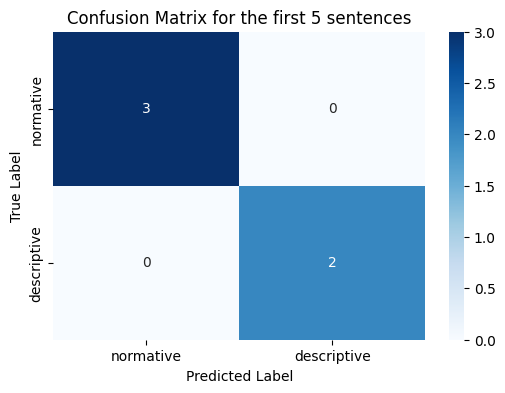

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compare the actual and predicted labels for the first 5 rows
comparison_subset = df.head(5)[['label', 'predicted_label']]
display(comparison_subset)

# Calculate accuracy for the subset
correct_predictions = (comparison_subset['label'] == comparison_subset['predicted_label']).sum()
total_predictions = len(comparison_subset)
accuracy_subset = correct_predictions / total_predictions if total_predictions > 0 else 0

print(f"\nAccuracy on the first 5 sentences: {accuracy_subset:.2f}")

# Calculate F1 score for the subset
# Ensure labels are consistent
comparison_subset['label'] = comparison_subset['label'].astype(str)
comparison_subset['predicted_label'] = comparison_subset['predicted_label'].astype(str)

# Handle potential missing predicted labels
comparison_subset.dropna(subset=['predicted_label'], inplace=True)

if len(comparison_subset) > 0:
    f1_subset = f1_score(comparison_subset['label'], comparison_subset['predicted_label'], average='weighted')
    print(f"F1 Score on the first 5 sentences: {f1_subset:.2f}")

    # Calculate confusion matrix for the subset
    cm_subset = confusion_matrix(comparison_subset['label'], comparison_subset['predicted_label'])

    # Display confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', xticklabels=comparison_subset['label'].unique(), yticklabels=comparison_subset['label'].unique())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for the first 5 sentences')
    plt.show()
else:
    print("Cannot calculate F1 score or confusion matrix for the subset as there are no valid predictions.")